# The HFM library - A fast marching solver with adaptive stencils

## Part : Application examples
## Chapter : Optimal routing of a boat

In this notebook, we compute the route that minimizes fuel consumption for a simplified boat model, with time-independent data, and without constraint on the arrival time. The instantaneous fuel consumption of the boat, moving a velocity $v$ at a position $x$, is a quadratic function
$$
    c(x,v) = \mu(x) + \frac 1 2 \| v - \omega(x) \|_{M(x)}^2.
$$
The parameters have the following interpretation:
- $\mu > 0$ is the fuel consumption at rest (or any other time penalty).
- $\omega$ is a drift velocity, due to e.g. water currents.
- $M \succ 0$ is a positive definite matrix describing the geometry around the position $x$ (which typically lies on a sphere, the earth). We denote $<v,w>_M := <v,M w>$ and $\|v\|_M := \sqrt{<v,v>_M}$.

**Discussion of the assumptions**

Our assumptions are obviously an strong simplification of reality. Some of them may be relaxed, at the price of more complexity in the implementation and in the modeling phase.
- *Time dependent data.* The data, e.g. the water currents, may be time dependent, so as to reflect the evolution of the weather conditions. This modification requires an entirely different set of methods, described in [another notebook](../Notebooks_NonDiv/BoatRouting_Time.ipynb).
- *Prescribed arrival time.* The arrival date of the boat may be fixed in advance. This can be handled with a small modification: consider the modified cost $\tilde c(x,v) = c(x,v) + \alpha$, where $\alpha>0$ is a constant penalizing travel-time. Then adjust the constant $\alpha$, using e.g. dichotomic search, so that the arrival time is the one prescribed.
- *More complex cost function.* The method described in this notebook applies with only little modifications to cost functions of the form
$$
    c(x,v) = \sup_{\lambda \in \Lambda} a_\lambda(x) + <b_\lambda(x),v> + \frac 1 2 \|v\|^2_{c_\lambda(x)}.
$$
Any cost which is convex and with at least quadratic growth at infinity, can be approximated in this form. However, determining this cost (which depends on the physical properties of the boat), and approximating it (fitting a convex set with an intersection of ellipsoids), may raise difficulties in itself.
- *Local controllability.* We do need that $c(x,v)<\infty$ for all $v$ in a neighborhood of the origin, in other words the boat is able to navigate in any direction, in any weather condition, for a sufficiently high fuel consumption. The time dependent formulation does not suffer from this restriction, see [the other notebook](../Notebooks_NonDiv/BoatRouting_Time.ipynb).
- *Additional state variables.* The boat state may include variables additional to position. For instance velocity if the boat has inertia, or the current state of the sails if any.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Constant medium](#1.-Constant-medium)
  * [2. Space-varying medium](#2.-Space-varying-medium)
    * [2.1 Variants](#2.1-Variants)
    * [2.2 Obtaining the travel time](#2.2-Obtaining-the-travel-time)
    * [2.3 Validation](#2.3-Validation)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('BoatRouting','FMM'))

In [2]:
from agd import Eikonal
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd.Metrics import Rander,Riemann
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig,quiver; #savefig.dirName = 'Images/BoatRouting'

In [3]:
import numpy as np; xp = np
from copy import copy
import matplotlib.pyplot as plt

Utility functions

In [4]:
norm_infinity = ad.Optimization.norm_infinity
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,lp,fd,Rander,Riemann,ad
    Eikonal,lp,fd,Rander,Riemann,ad = rreload([Eikonal,lp,fd,Rander,Riemann,ad],"../..")

### 0.1 Optional configuration
Uncomment the following line to use the GPU eikonal solver.

In [6]:
xp,plt,quiver,Eikonal = map(ad.cupy_friendly,(xp,plt,quiver,Eikonal))

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Returning a copy of function quiver which accepts cupy arrays as input.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .


## 1. Constant medium

We assume in this section that the cost is independent of the position $c=c(v)$. In other words, the fuel consumption at rest $\mu>0$, the water currents $\omega$, and the problem geometry $M\succ 0$ are independent of time.

Assume that the boat needs to move from the origin to a prescribed position $z$, without time constraint. 
The optimal path is to go straight toward the objective, and the minimal cost is thus 
$$
    N(z) := \inf_{t>0} \ t \ c(z/t).
$$
For the quadratic cost model, this problem reads 
$$
    N(z) = \min_{t>0} \ t \ \Big(\mu + \frac 1 2 \big\|\frac z t -\omega\big\|_M^2\Big).
$$
It is easily solvable (exercise), and the optimal time is 
$$
    t_opt = \frac {\|z\|_M}{\sqrt{2 \mu + \|\omega\|_M^2}},
$$
whereas the minimal cost reads 
$$
    N(z) = \|z\|_M \sqrt{2 \mu + \|\omega\|_M^2} - <\omega,z>_M.
$$

<!---
Assume that the boat travels for some time $t$, with instantaneous fuel consumption $\rho$, and with constant unit direction $u$, which is are unknowns of the problem. By our assumptions, the boat reaches the point 
$$
    v = (u\sqrt \rho + \omega) t, 
$$
and one has by assumption $\|u\|_M = 1$. In the next section, the positive definite matrix $M$ will be used to describe the earth geometry. The cost of this particular travel is 
$$
    (\rho+\alpha) t,
$$
which is the sum of the total fuel consumption $\rho t$, and the travel time $t$ weighted by $\alpha$.

Minimizing over $t,\rho,u$, subject to the constraint that the endpoint $v$ is met, a simple analysis yields that the cost of this travel is $2 N_\alpha(v)$ where
$$
    N_\alpha(v) := \|v\|_M \sqrt{ \|\omega\|_M^2+\alpha} - <v,\omega>_M.
$$
The optimal parameters $(t_{\min},\rho_{\min},u_{\min})$ are characterized by 
$$
    t_{\min} = \frac {\|v\|_M} {\sqrt{\|\omega\|_M^2 +\alpha}},
$$
from which one easily deduces $\rho_{\min}$ and $u_{\min}$.
--->

In [7]:
def route_min(z,params):
    z,μ,ω,M = fd.common_field((z,)+params, depths=(1,0,1,2))
    z_norm = np.sqrt(lp.dot_VAV(z,M,z))
    μω_norm = np.sqrt( 2*μ +lp.dot_VAV(ω,M,ω) )
    cost = z_norm*μω_norm - lp.dot_VAV(z,M,ω)
    time = z_norm / μω_norm
    fuel = cost/time
    rvel = z/time - ω
    return {
        'cost':cost, # minimal cost for this travel
        'time':time, # optimal travel time 
        'fuel':fuel, # instantaneous fuel consumption
        'rvel':rvel, # relative velocity, w.r.t current
    }

The cost $N(z)$ takes the form of a Rander norm, a.k.a the sum of a distorted euclidean norm and of a linear function. Note that the Rander compatibility condition is satisfied: $N(z)\geq 0$ for all $z$. The more general cost considered in the introduction would yields a supremum of functions of this form.

In [8]:
def metric(params):
    μ,ω,M = fd.common_field(params,depths=(0,1,2))
    return Rander( M*(2*μ + lp.dot_VAV(ω,M,ω)), -lp.dot_AV(M,ω))

In [9]:
# Generate a cartesian grid
aX = xp.linspace(-1,1)
X = ad.array(np.meshgrid(aX,aX,indexing='ij'))

The following observations can be made.
- It is cheaper to travel in the direction of the water currents. (As expected.)
- The travel time is symmetric w.r.t. $z$. This was expected in view of the above formula, but it is nonetheless surprising.
- The instantaneous fuel consumption only depends on the direction, not the travel time. It is stronger when one goes against the water currents. (As expected for a time independent problem.)
- The boat does not head straight where it needs to go, but moves like a crab, taking avantage (or fighting against) water currents.

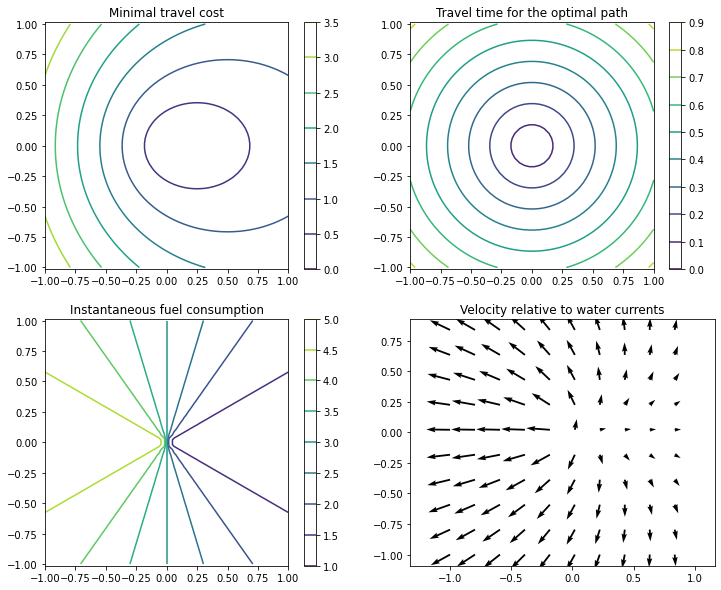

In [10]:
# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
params = (1.,xp.array((1.,0.)),xp.eye(2))
route = route_min(X,params)
assert np.allclose(metric(params).norm(X),route['cost'])

plt.figure(figsize=[12,10])

plt.subplot(2,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,route['cost']); plt.colorbar()

plt.subplot(2,2,2); plt.axis('equal')
plt.title('Travel time for the optimal path')
plt.contour(*X,route['time']); plt.colorbar()

plt.subplot(2,2,3); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel']); plt.colorbar()

plt.subplot(2,2,4); plt.axis('equal')
plt.title('Velocity relative to water currents')
quiver(*X,*route['rvel'],subsampling=(5,5))

By setting $\mu=0$, we do not penalize travel time. In that case:
- the minimal travel cost vanishes in the direction of the drift.
- the travel time increases, but not indefinitely. Indeed, excessively long paths would use more fuel in total.

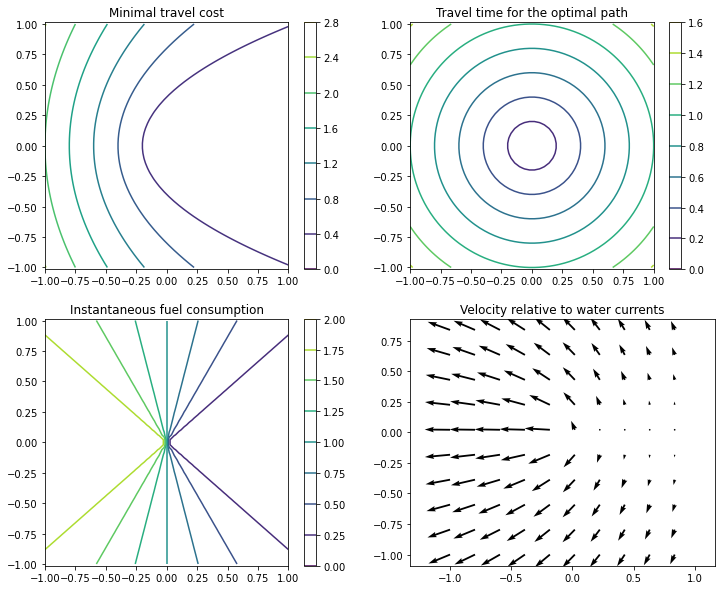

In [11]:
# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
params = (0.,xp.array((1.,0.)),xp.eye(2))
route = route_min(X,params)

plt.figure(figsize=[12,10])

plt.subplot(2,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,route['cost']); plt.colorbar()

plt.subplot(2,2,2); plt.axis('equal')
plt.title('Travel time for the optimal path')
plt.contour(*X,route['time']); plt.colorbar()

plt.subplot(2,2,3); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel']); plt.colorbar()

plt.subplot(2,2,4); plt.axis('equal')
plt.title('Velocity relative to water currents')
quiver(*X,*route['rvel'],subsampling=(5,5))

By setting $\mu$ to a large value, we strongly penalize travel time. In that case:
- the minimal travel cost is almost isotropic. Indeed, the boat must go fast, to reduce travel time, hence the drift becomes negligible.
- the instantaneous fuel consumption is almost independent of the direction, and the boat heads straight where it needs to go. Again, this is because the boat goes fast, so that drift is negligible.

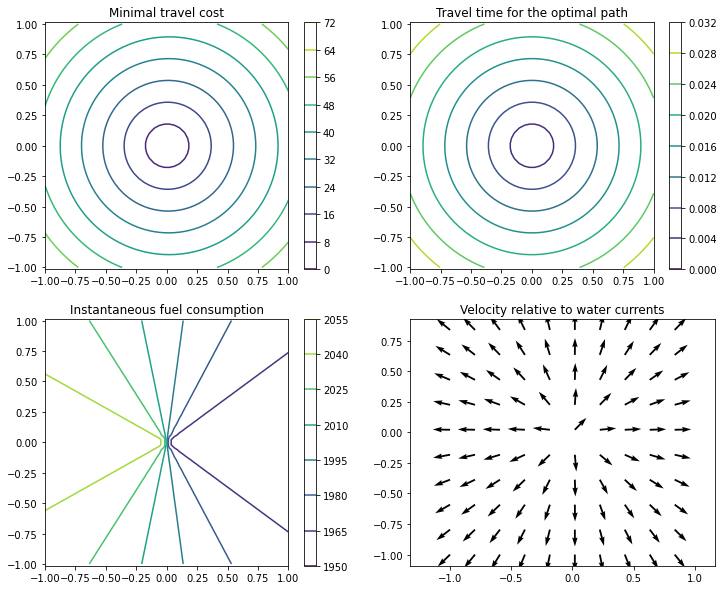

In [12]:
# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
params = (1e3,xp.array((1.,0.)),xp.eye(2))
route = route_min(X,params)

plt.figure(figsize=[12,10])

plt.subplot(2,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,route['cost']); plt.colorbar()

plt.subplot(2,2,2); plt.axis('equal')
plt.title('Travel time for the optimal path')
plt.contour(*X,route['time']); plt.colorbar()

plt.subplot(2,2,3); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel']); plt.colorbar()

plt.subplot(2,2,4); plt.axis('equal')
plt.title('Velocity relative to water currents')
quiver(*X,*route['rvel'],subsampling=(5,5))

## 2. Space-varying medium

In this section, we considere a setup with space dependent geometry, water currents, and obstacles.
Finding the optimal route requires solving an eikonal equation, which we do using the HFM library.

The first step is to define the location of the obstacles, the starting point, and the target points.

In [13]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2', # Riemannian + drift, what is needed here
    'exportValues':1,
    'exportGeodesicFlow':1,
    'seed':[-1.7,0.6], # Where to start the front propagation
})
hfmIn.SetRect([[-2,2],[-1,1]],dimx=200) # Rectangular domain
X = hfmIn.Grid() # Coordinate system
hfmIn['walls'] = X[1]-np.abs(X[0])>=0 # Obstacles in the domain
hfmIn.SetUniformTips((6,3)) # Points from which to backtrack geodesics

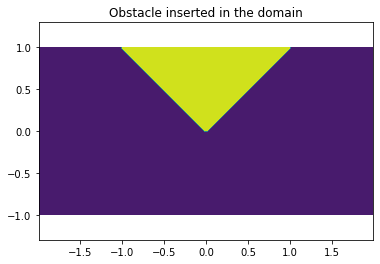

In [14]:
plt.title('Obstacle inserted in the domain'); plt.axis('equal')
plt.contourf(*X, hfmIn['walls']);

We now define the Riemannian metric $M$. Here, we choose the metric attached to a sphere, a.k.a. the earth, of radius one. Recall that the intrinsic metric on a manifold embedded in Euclidean space is 
$$
    M(x) = df(x)^T df(x) = \nabla f(x) \nabla f(x)^T,
$$
where $df$ is the differential of $f$, and $\nabla f(x) := df(x)^T$. 

In [15]:
def Spherical(θ,ϕ): 
    """Spherical embedding: θ is longitude, ϕ is latitude from equator toward pole"""
    return (np.cos(θ)*np.cos(ϕ), np.sin(θ)*np.cos(ϕ), np.sin(ϕ))

def IntrinsicMetric(Embedding,*X):
    """Riemannian metric for a manifold embedded in Euclidean space"""
    X_ad = ad.Dense.identity(constant=X,shape_free=(2,)) # First order dense AD variable
    Embed_ad = ad.asarray(Embedding(*X_ad)) # Differentiate the embedding
    Embed_grad = Embed_ad.gradient()
    Embed_M = lp.dot_AA(Embed_grad,lp.transpose(Embed_grad)) # Riemannian metric
    return Embed_M

We now choose the water (surface) currents, arbitrarily. They are defined in the local chart $\theta,\phi$, and not on the three dimensional sphere, for simplicity.

In [16]:
def bump(x,y): 
    """Gaussian-like bump (not normalized)"""
    return np.exp(-(x**2+y**2)/2)

def Currents(θ,ϕ):
    """Some arbitrary vector field (water currents)"""
    bump0 = bump(θ+1,(ϕ+0.3)*2); ω0=(0,1) # intensity and direction of the currents
    bump1 = 2*bump(2*(θ-0.7),ϕ-0.2); ω1=(1,-1)
    bump0,ω0,bump1,ω1 = fd.common_field( (bump0,ω0,bump1,ω1), depths=(0,1,0,1))
    return bump0*ω0+bump1*ω1

We have put two strong currents:
- One in the west, towards north. One can however get around it, east or west.
- One in east, towards south-east. One cannot get around this one, but it is nevertheless weaker in the south than the north.

In [17]:
Embed_ω = Currents(*X)
Embed_M = IntrinsicMetric(Spherical,*X) # Actually a diagonal matrix, but we don't exploit this fact here

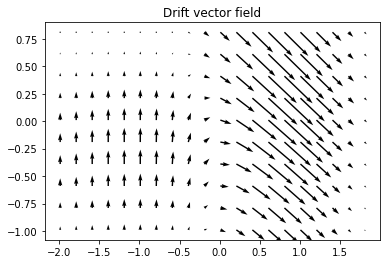

In [18]:
plt.title('Drift vector field')
quiver(*X,*Embed_ω,subsampling=(10,10))

In [19]:
params = (1.,Embed_ω,Embed_M) # Idle fuel consumption μ = 1 
hfmIn['metric'] = metric(params) 

It is worth noting that the problem metric is quite strongly anisotropic, due to the presence of strong currents. Recall that the anisotropy, at a given point, is the maximum ratio of the travel cost from that point in two different directions of unit Euclidean norm. A.k.a it is much cheaper to be pushed by the current than to go against it.

In [20]:
#np.max(hfmIn['metric'].anisotropy_bound()) # only an upper bound. (May be slow on GPU)

The problem is already anisotropic (but not asymmetric) without the currents, due to the geometry of the sphere. However, that anisotropy is much less pronounced.

In [21]:
np.max(Riemann(Embed_M).anisotropy()) 

array(1.8225235, dtype=float32)

In [22]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.03649091720581055 seconds, and 37 iterations.
Post-Processing


Some observations : 
- On the west, one sees as expected that the optimal paths get around the strong current by both sides. This creates a non-differentiability in the value function.
- On the east, the south-east current is very strong. The minimal paths which need to go north follow the current it until they can get out of it, at $\theta\approx 1.5$, and then they change direction.

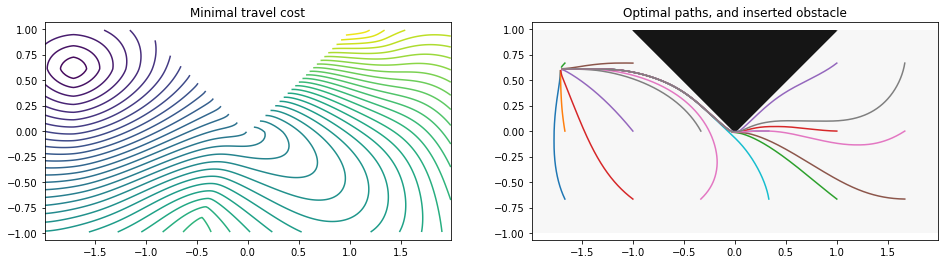

In [23]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,hfmOut['values'],levels=50)

plt.subplot(1,2,2); plt.axis('equal')
plt.title('Optimal paths, and inserted obstacle')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

The HFM library exports the geodesic flow, which is the local direction of the minimal geodesics coming from the seed point. Using this quantity we can recover the instantaneous fuel consumption, and the relative velocity of the boat. One observes that:
- the fuel consumption is highest when the boat needs to go against water currents.
- in the west the boat direction is almost opposite to the current (water current in the face), whereas in the east the boat direction is often almost othogonal to the current (water current in the back).

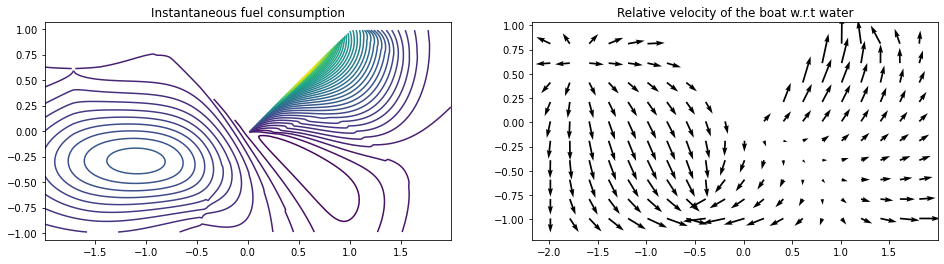

In [24]:
v = hfmOut['flow']
v[:,ad.Optimization.norm(v,axis=0)==0] = np.nan # Avoid division by zero where there is no velocity (walls, seed)
route = route_min(v,params)

plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel'],levels=50)

plt.subplot(1,2,2); plt.axis('equal')
plt.title('Relative velocity of the boat w.r.t water')
quiver(*X,*route['rvel'],subsampling=(10,10))

One may also recover the total fuel consumption, and the total travel time, integrated along the geodesics, by solving one additional first order PDE. 

### 2.1 Variants

We can increase the cost of time. As before, if we increase it a lot, then the drift due to water currents becomes negligible.

In [25]:
params = (1e3,Embed_ω,Embed_M) # Strong idle fuel consumption μ
hfmIn['metric'] = metric(params) 
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.017998695373535156 seconds, and 38 iterations.
Post-Processing


In the limit, as $\alpha \to \infty$, the geodesics coincide with the great circles on the sphere - except when they hit the obstacles or the domain boundary.

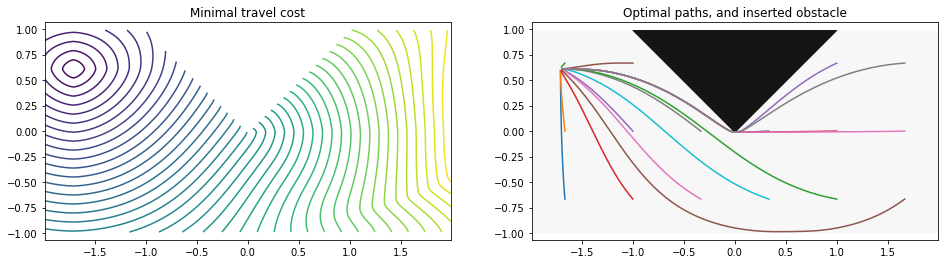

In [26]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title('Minimal travel cost')
plt.contour(*X,hfmOut['values'],levels=50)

plt.subplot(1,2,2); plt.axis('equal')
plt.title('Optimal paths, and inserted obstacle')
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

The fuel consumption varies much less, and the boat heads directly where it needs to go.

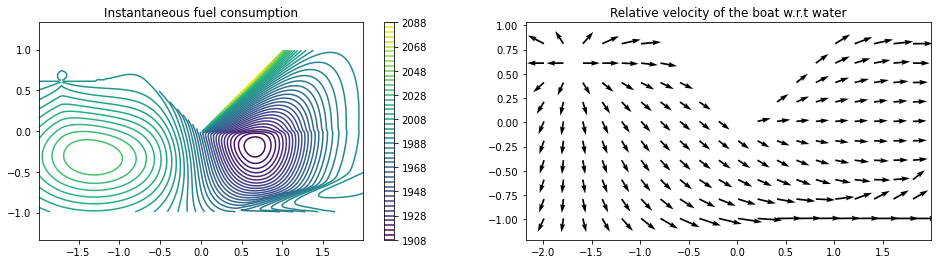

In [27]:
v = hfmOut['flow']
v[:,ad.Optimization.norm(v,axis=0)==0] = np.nan # Avoid division by zero where there is no velocity (walls, seed)
route = route_min(v,params)

plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title('Instantaneous fuel consumption')
plt.contour(*X,route['fuel'],levels=50); plt.colorbar()

plt.subplot(1,2,2); plt.axis('equal')
plt.title('Relative velocity of the boat w.r.t water')
quiver(*X,*route['rvel'],subsampling=(10,10))

In one removes the drift (equivalently $\alpha \to \infty$), the instantaneous fuel consumption becomes constant along the journey, which is expected.

In [28]:
params = (1.,(0,0),Embed_M) # Weight α = 1 for time w.r.t fuel
hfmIn['metric'] = metric(params) 
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.016475439071655273 seconds, and 39 iterations.
Post-Processing


In [29]:
v = hfmOut['flow']
v[:,ad.Optimization.norm(v,axis=0)==0] = np.nan # Avoid division by zero where there is no velocity (walls, seed)
route = route_min(v,params)

print(f"Extremes of fuel instantaneous consumption. min={np.nanmin(route['fuel'])}, max={np.nanmax(route['fuel'])}")

Extremes of fuel instantaneous consumption. min=1.9999998, max=2.0


### 2.2 Obtaining the travel time

In order to obtain the arrival time at some destination, we must integrate it along the geodesic.
We take advantage of the automatic differentiation capabilities of the HFM library, in a somewhat hacky way, to perform this integration and obtain the arrival times.

In [30]:
def ArrivalTime(hfmIn,params):
    hfmIn = copy(hfmIn) 
    hfmIn['metric'] = metric(params)
    hfmIn['exportGeodesicFlow']=1
    cache = Eikonal.Cache(needsflow=True)
    hfmOut = hfmIn.Run(cache=cache)
    
    flow = hfmOut['flow']
    no_flow = np.all(flow==0,axis=0)
    flow[:,no_flow]=np.nan  # No flow at the seed point, avoid zero divide
    flow_norm = hfmIn['metric'].norm(flow)
    route = route_min(flow,params)
    costVariation = route['time']/flow_norm
    costVariation[no_flow] = 0
    hfmIn['costVariation'] = np.expand_dims(costVariation,axis=-1)
    
    hfmOut2 = hfmIn.Run(cache=cache) # cache avoids some recomputations
    time = hfmOut2['values'].gradient(0)
    return time,hfmOut

In [31]:
params = (1.,Embed_ω,Embed_M) # Idle fuel consumption μ = 1 
arrival_time,hfmOut = ArrivalTime(hfmIn,params)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.01700139045715332 seconds, and 37 iterations.
Post-Processing
Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.014996051788330078 seconds, and 37 iterations.
Post-Processing


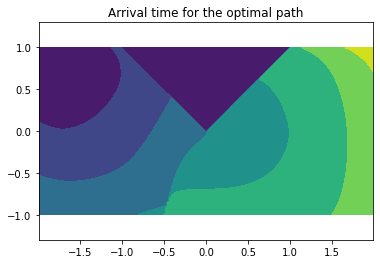

In [32]:
plt.title('Arrival time for the optimal path'); plt.axis('equal')
plt.contourf(*X,arrival_time);

### 2.3 Validation

We compare the exact analytical solution and the numerical solution in the case of a constant medium, for validation.

In [33]:
hfmIn = Eikonal.dictIn({
    'verbosity':0,
    'model':'Rander2',
    'exportValues':1,
    'seed':[0,0],
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=101,sampleBoundary=True)

In [34]:
params = (1.,xp.array((0.,1.)),xp.eye(2))
arrival_time,hfmOut = ArrivalTime(hfmIn,params)

In [35]:
X = hfmIn.Grid()
route = route_min(X,params)

In [36]:
assert norm_infinity(arrival_time - route['time']) < 0.02
assert norm_infinity(hfmOut['values'] - route['cost']) < 0.05